In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors,datasets
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.datasets.samples_generator import make_classification

In [2]:
%matplotlib inline

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.slinear = nn.Linear(2, 10)
        self.mlinear = nn.Linear(10, 2)
        self.olinear = nn.Linear(2, 4)
    def forward(self, seq):
        ss = F.sigmoid(self.slinear(seq))
        ss = F.sigmoid(self.mlinear(ss))
        out = self.olinear(ss)
        return ss,out

In [8]:
X,y = make_classification(n_samples = 1000,
                          weights=[0.9, 0.04, 0.04],
                          n_features=2,
                          n_redundant=0,
                          n_clusters_per_class=1, 
                          n_classes=4)
train_var = Variable(torch.FloatTensor(X)).cuda()
train_label = Variable(torch.LongTensor(y)).cuda()

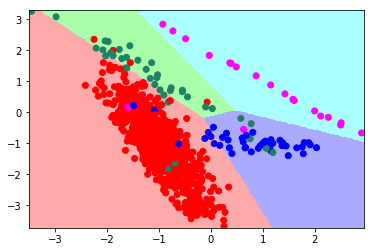

In [9]:
def draw(X, y):
    clf = LogisticRegression(multi_class='multinomial',solver ='newton-cg')
    clf.fit(X,y)
    h =.02
    x_min,x_max =X[:,0].min()-0.05,X[:,0].max()+0.05
    y_min,y_max =X[:,1].min()-0.05,X[:,1].max()+0.05
    xx,yy =np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h)) #生成网格型二维数据对
    Z =clf.predict(np.c_[xx.ravel(),yy.ravel()])
    cmap_light =ListedColormap(['#FFAAAA','#AAFFAA','#AAAAFF','#AAFFFF'])#给不同区域赋以颜色
    cmap_bold =ListedColormap(['#FF0000','#1e8364','#0000FF','#FF00FF'])#给不同属性的点赋以颜色
    Z =Z.reshape(xx.shape)
    plt.pcolormesh(xx,yy,Z,cmap=cmap_light)
    plt.scatter(X[:,0],X[:,1],c=y,cmap=cmap_bold) # 也画出所有的训练集数据
    plt.xlim(xx.min(),xx.max())
    plt.ylim(yy.min(),yy.max())
    plt.show()
draw(X,y)

epoch: 1000 loss: 0.151490807533 acc: 0.957


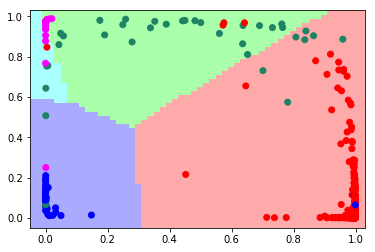

epoch: 2000 loss: 0.105432204902 acc: 0.981


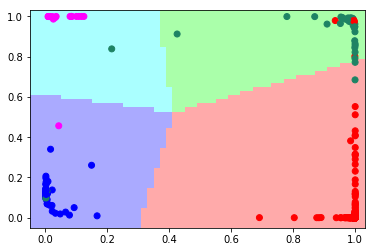

epoch: 3000 loss: 0.0969895347953 acc: 0.983


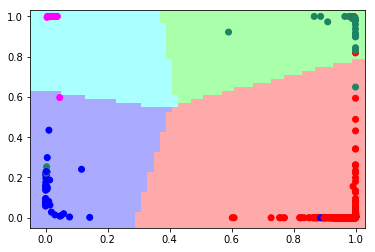

epoch: 5000 loss: 0.0883292481303 acc: 0.984


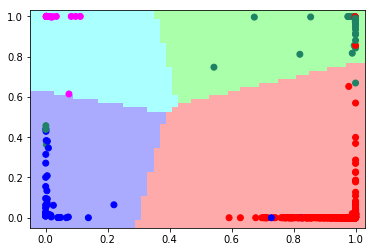

epoch: 6000 loss: 0.0822945088148 acc: 0.986


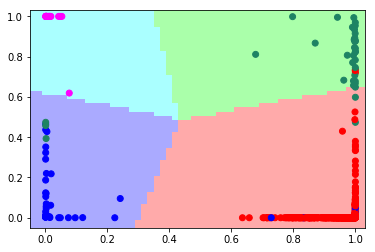

In [10]:
model = Model().cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
acc_index = 0
for epoch in range(10000):
    torch.cuda.empty_cache()
    model.zero_grad()
    mid,tag_scores = model(train_var)
    values, indices = tag_scores.max(1)
    accurate = indices.eq(train_label).data.float().sum()
    loss = loss_function(tag_scores, train_label)
    loss.backward()
    optimizer.step()
    
    if epoch == 0:
        acc_index = accurate/len(X)
    if epoch % 1000 == 0:
        if acc_index != accurate/len(X):
            print 'epoch:',epoch,'loss:',loss.data[0],'acc:',accurate/len(X)
            acc_index = accurate/len(X)
            draw(np.array(mid.data.tolist()), y)